In [33]:
from Udep2Mono.binarization import BinaryDependencyTree
from Udep2Mono.polarization import PolarizationPipeline
from Udep2Mono.util import btreeToList
from copy import deepcopy

from allennlp.predictors.predictor import Predictor
import allennlp_models.structured_prediction

ie_extractor = Predictor.from_path("https://storage.googleapis.com/allennlp-public-models/openie-model.2020.03.26.tar.gz")

In [35]:
import os

from nltk.tree import Tree
from nltk.draw import TreeWidget
from nltk.draw.util import CanvasFrame
from IPython.display import Image, display

def jupyter_draw_nltk_tree(tree):
    cf = CanvasFrame()
    tc = TreeWidget(cf.canvas(), tree)
    tc['node_font'] = 'arial 14 bold'
    tc['leaf_font'] = 'arial 14'
    tc['node_color'] = '#005990'
    tc['leaf_color'] = '#3F8F57'
    tc['line_color'] = '#175252'
    cf.add_widget(tc, 20, 20)
    os.system('rm -rf ../data/tree.png')
    os.system('rm -rf ../data/tree.ps')
    cf.print_to_file('../data/tree.ps')
    cf.destroy()
    os.system('magick convert ../data/tree.ps ../data/tree.png')
    display(Image(filename='../data/tree.png'))

In [48]:
from pattern.en import pluralize, singularize

def fix_info(desc):
    out = desc.replace("ARG0: ", "")
    out = out.replace("ARG1: ", "")
    out = out.replace("V: ", "")
    out = out.replace("[", "")
    out = out.replace("]", ",")
    out = out.split(",")
    out = list(map(lambda x: x.strip(), out))
    out = list(map(lambda x: x.split(" "), out))
    return out

# TODO: Verb Phrase Patterns
# 1.Intransitive: subject + VI
# 2.Linking: subject + VL + NP/AdjP
# 3.Transitive: subject + VT + NP
# 4.Ditransitive: subject + VD + NP(indirect) + NP(direct)
# 5.Complex Transitive: subject + VC + NP(direct) + NP/AdjP
# 6.Open clausal complement: VB + to/that VP
class PhrasalGenerator:
    def __init__(self):
        self.deptree = None
        self.annotated = None
        self.kb = {}
        self.tree_log = []
        self.sent_log = []
        self.mod_at_left = [
            "advmod", "amod", "advmod:count", "acl:relcl"]
        self.mod_at_right = []
        
        '''
            "appos": self.generate_inherite,
            "aux": self.generate_aux,
            "aux:pass": self.generate_aux,
            "case": self.generate_case,
            "cc": self.generate_cc,
           
            "ccomp": self.generate_ccomp,
            "compound": self.generate_inherite,
            "compound:prt": self.generate_inherite,
            "conj": self.generate_inherite,
            "cop": self.generate_inherite,
            
            "expl": self.generate_expl,
            "nmod": self.generate_nmod,
            "nmod:npmod": self.generate_nmod,
            "nmod:tmod": self.generate_nmod,
            "nmod:poss": self.generate_nmod_poss,
            
            "nummod": self.generate_nummod,
            "obl": self.generate_obj,
            "obl:npmod": self.generate_oblnpmod,
            "obl:tmod": self.generate_inherite,
            "xcomp": self.generate_obj
        '''

    def deptree_generate(self, tree, annotated, original):
        self.tree_log = []
        self.sent_log = []
        self.deptree = tree
        self.annotated = annotated
        self.ie_pred = {}
        verbs = ie_extractor.predict(original)['verbs']
        for verb in verbs:
            self.ie_pred[verb['verb']] = fix_info(verb['description'])
            # print(self.ie_pred[verb['verb']])
        
        self.generate(self.deptree)

    def generate(self, tree):
        if tree.val in self.mod_at_left:
            self.left_modifier_generate(tree)
        elif tree.val == "conj" and tree.mark == "+":
            self.generate_conj(tree)
        elif tree.left != "N":
            self.generate_default(tree)

    def delete_left_modifier(self, tree):
        tree.val = tree.right.val
        tree.mark = tree.right.mark
        tree.npos = tree.right.npos
        tree.id = tree.right.id
        tree.left = tree.right.left
        tree.right = tree.right.right

    def rollback(self, tree, backup):
        tree.val = backup.val
        tree.left = deepcopy(backup.left)
        tree.right = deepcopy(backup.right)
        tree.mark = backup.mark
        tree.npos = backup.npos
        tree.id = backup.id

    def left_modifier_generate(self, tree):
        # adv + VB | VB + adv => VB
        # amod + Noun => Noun
        # Noun + relcl => Noun
        left = tree.left
        right = tree.right
        backup = deepcopy(tree)

        if right.mark == "+":
            self.delete_left_modifier(tree)
            self.save_tree(isTree=True)
            self.rollback(tree, backup)    

    def rollback_annotation(self, generated, original):
        word_id = self.annotated[generated]
        del self.annotated[generated]
        self.annotated[original] = word_id

    def generate_conj(self, tree):
        backup = deepcopy(tree)
        self.left_modifier_generate(tree)
    
        tree.val = tree.left.right.val
        tree.mark = tree.left.right.mark
        tree.npos = tree.left.right.npos
        tree.id = tree.left.right.id
        tree.left = backup.left.right.left
        tree.right = backup.left.right.right
        print(tree.right.val)
        self.save_tree(isTree=True)
        self.rollback(tree, backup)

    def generate_default(self, tree):
        left = tree.left
        right = tree.right

        if right.npos is not None:
            if "NN" in right.npos and right.mark == "-":
                for adj in kb["ADJ"]:
                    generated = ' '. join([adj, right.val])
                    word_id = self.annotated[right.val]
                    del self.annotated[right.val]
                    self.annotated[generated] = word_id
                    self.save_tree(isTree=False)
                    self.rollback_annotation(generated, right.val)
                for rel in kb["RCL"]:
                    generated = ' '. join([right.val, rel])
                    word_id = self.annotated[right.val]
                    del self.annotated[right.val]
                    self.annotated[generated] = word_id
                    self.save_tree(isTree=False)
                    self.rollback_annotation(generated, right.val)
            elif "VB" in right.npos and right.mark == "-":
                for adv in kb["ADV"]:
                    generated = ' '. join([adv, right.val])
                    word_id = self.annotated[right.val]
                    del self.annotated[right.val]
                    self.annotated[generated] = word_id
                    self.save_tree(isTree=False)
                    self.rollback_annotation(generated, right.val)

                    description = self.ie_pred[right.val]
                    arg1 = description[2][-1]
                    generated = ' '.join([arg1, adv])
                    word_id = self.annotated[arg1]
                    del self.annotated[arg1]
                    self.annotated[generated] = word_id
                    self.save_tree(isTree=False)
                    self.rollback_annotation(generated, arg1)

        self.generate(left)
        self.generate(right)  

    def save_tree(self, isTree):
        if isTree:
            self.tree_log.append(deepcopy(self.deptree))
        else:
            self.sent_log.append(deepcopy(self.annotated))
        
    def buildTree(self, config):
        left = BinaryDependencyTree(
            config['mod'], "N", "N", 1024, 
            wid=config['lid'], npos="JJ")
        right = BinaryDependencyTree(
            config['head'], "N", "N", 1024,
            wid=config['rid'], npos="NN")
        tree = BinaryDependencyTree(config['rel'], left, right, 1025)
        left.mark = config['mark']
        right.mark = config['mark']
        tree.mark = config['mark']
        return tree

100%|██████████| 4/4 [00:00<00:00,  6.54it/s]

Polarization Complete
Init Premise:  some↑ red↑ flowers↑ need↑ light↑


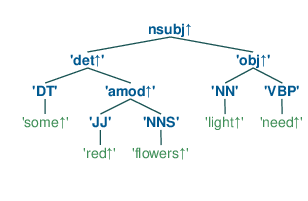

Next Premise:  some↑ flowers↑ need↑ light↑
Init Premise:  all↑ flowers↓ need↑ light↑


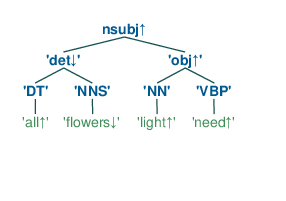

Next Premise:  all beautiful flowers need light
Next Premise:  all red flowers need light
Next Premise:  all fragret flowers need light
Next Premise:  all flowers which is beautiful need light
Next Premise:  all flowers which opens at night need light
Init Premise:  no↑ flowers↓ need↓ bright↓ light↓


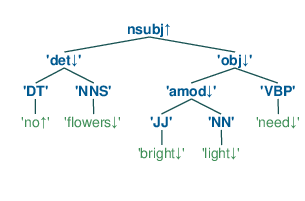

Next Premise:  no beautiful flowers need bright light
Next Premise:  no red flowers need bright light
Next Premise:  no fragret flowers need bright light
Next Premise:  no flowers which is beautiful need bright light
Next Premise:  no flowers which opens at night need bright light
Next Premise:  no flowers ergently need bright light
Next Premise:  no flowers need bright light ergently
Next Premise:  no flowers clearly need bright light
Next Premise:  no flowers need bright light clearly
Next Premise:  no flowers neccesaraly need bright light
Next Premise:  no flowers need bright light neccesaraly
Init Premise:  john↑ ate↑ an↑ apple↑ and↑ finished↑ his↑ homework↑


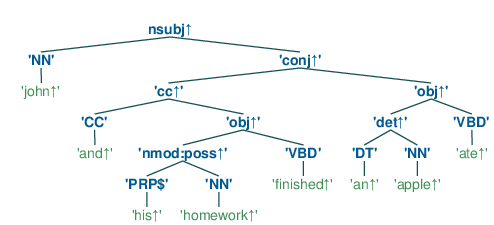

finished
Next Premise:  john↑ ate↑ an↑ apple↑
Next Premise:  john↑ finished↑ his↑ homework↑


In [49]:
sentences = ["Some red flowers need light", 
             "All flowers need light", 
             "No flowers need bright light",
             "John ate an apple and finished his homework"]
kb = {"ADJ": ["beautiful", "red", "fragret"], 
      "ADV": ["ergently", "clearly", "neccesaraly"],
      "RCL": ["which is beautiful", "which opens at night"]}

pipeline = PolarizationPipeline(sentences, verbose=2, parser="stanza")
pipeline.run_polarize_pipeline()
print("\nPolarization Complete")

phrasalGenerator = PhrasalGenerator()
for annotation in pipeline.annotations:
    print("================")
    print("Init Premise: ", annotation['annotated'])
    polarized = annotation['polarized']
    btreeViz = Tree.fromstring(polarized.replace('[', '(').replace(']', ')'))
    jupyter_draw_nltk_tree(btreeViz) 
    phrasalGenerator.kb = kb
    phrasalGenerator.deptree_generate(
        annotation['polarized_tree'], annotation['word_dict'], annotation['original'])
    for gen_tree in phrasalGenerator.tree_log:
        generated, queue, _, _ = btreeToList(gen_tree, len(annotation['original']), {}, 0)
        annotated = list(queue.popkeys())
        print("Next Premise: ", ' '.join(annotated))
    for gen_sent in phrasalGenerator.sent_log:
        print("Next Premise: ", ' '.join(gen_sent.popkeys()))
    